# Homework 4 - Pawpularity

It's time to train your first model on ~cats~ real data. The dataset of cute pets is avaialble here -  [Pawpularity Contest - Predict the popularity of shelter pet photos](https://www.kaggle.com/c/petfinder-pawpularity-score/data)


Your task is to predict engagement with a pet's profile based on the photograph for that profile. You are also provided with hand-labelled metadata for each photo. The dataset for this competition therefore comprises both images and tabular data.

In this homework we'll only use tabular meta data. Our goal is to fit linear reggresion on binary features. Let's see if we can do it better than predicting a constant.
![PetFinder.my - Pawpularity Contest](https://www.petfinder.my/images/cuteness_meter-showcase.jpg)

In [3]:
from typing import Union
from copy import copy
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model._base import LinearModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline

sns.set(rc={'figure.figsize':(14,9)})
%matplotlib inline

In [4]:
data = pd.read_csv('data/train.csv') #  date taken from train.csv from https://www.kaggle.com/c/petfinder-pawpularity-score/data

In [5]:
data.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


Let's create train/test split. We keep 20% of data for testing model performance

In [6]:
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data.Pawpularity)
train.shape, test.shape

((7929, 14), (1983, 14))

In [7]:
# Check that you have the same train/test split as others
assert(train.iloc[5].Pawpularity == 13)
assert(train.iloc[-5].Face == 1)
assert(test.iloc[5].Group == 1)
assert(test.iloc[-5].Pawpularity == 39)

### Baseline

Create a copy for test dataset:

In [8]:
test_copy = test.copy()

Set baseline based on mean/median/mode:

In [9]:
# trying different approaches 
test_copy['baseline_mean'] = int(round(test_copy['Pawpularity'].mean(), 0))
test_copy['baseline_median'] = int(round(test_copy['Pawpularity'].median(), 0))
test_copy['baseline_mode'] = int(round(test_copy['Pawpularity'].mode()[1], 0))

# calculating mean error for each method and selecting minimum error
# among outhers 
baselines = ['baseline_mean', 'baseline_median', 'baseline_mode']
min_error = (float('inf'), None)
for baseline_col in baselines:
    error = mean_squared_error(test_copy.Pawpularity, getattr(test_copy, baseline_col), squared=False)
    if error < min_error[0]:
        min_error = (error, baseline_col)

print(f'For baseling would be used {min_error[1].split("_")[1]} value of Pawpularity column')
print(f'It produce lowest mean squared error: {min_error[0]:.5f}')

# assing value to corresponding column and drop columns involved
test_copy['baseline'] = test_copy[f'{min_error[1]}']
test_copy.drop(columns=baselines, inplace=True)

For baseling would be used mean value of Pawpularity column
It produce lowest mean squared error: 20.61757


### Regression

Let's try to train linear regression on binary features

In [10]:
# let's remember the lowest error
min_error = [float('inf'), '']

In [11]:
features = data.columns[1:-1]
features

Index(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group',
       'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],
      dtype='object')

In [12]:
# dividing datasets to X and y
X_train = train[train.columns[1:-1]]
y_train = train['Pawpularity']

X_test = test_copy[test_copy.columns[1:-2]]
y_test = test_copy['Pawpularity']

In [13]:
def print_model_results(
    model: Union[LinearModel, Pipeline],
    df: pd.DataFrame,
    df_result_column_name: str,
    model_name: str,
    min_error_: list,
):
    """
    Printing model performance
    
    :param model: regression objects or pipeline
    :param df: test dataframe with prediction column
    :param df_result_column_name: name of the column with prediction
    :param model_name: name of model and methods that was used to achive results 
    """
    error = mean_squared_error(test_copy.Pawpularity, getattr(test_copy, df_result_column_name), squared=False)
    print(f'{model_name} mean squared error: {error:.5f}')
    if not isinstance(model, Pipeline):
        print(f'Bias: {model.intercept_}\nCoefs:')
        pprint(list(zip(features, model.coef_)))
    if error < min_error_[0]:
        min_error_[0] = error
        min_error_[1] = model_name

#### Basic linear regression

In [14]:
# Train model
model = LinearRegression()
model.fit(X_train, y_train)
test_copy['pred_linear_basic'] = model.predict(X_test)

In [15]:
print_model_results(model, test_copy, 'pred_linear_basic', 'LinearRegression', min_error)

LinearRegression mean squared error: 20.61321
Bias: 37.75776263342275
Coefs:
[('Subject Focus', -1.3184191941228067),
 ('Eyes', -1.924796216229895),
 ('Face', 2.1074415988073683),
 ('Near', 0.01681275070247746),
 ('Action', -0.9241970093570023),
 ('Accessory', 1.2659010714806036),
 ('Group', 1.105205350876324),
 ('Collage', 0.6555508044163164),
 ('Human', 0.219805018921125),
 ('Occlusion', -0.24853320175797664),
 ('Info', -1.4531318086129819),
 ('Blur', -3.957873216082744)]


In [16]:
# Define the hyperparameters to tune for LinearRegression
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'n_jobs': [-1]
}

# Create an instance of the linear regression model
model = LinearRegression()

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'fit_intercept': True, 'n_jobs': -1, 'positive': True}
Best score:  -0.0026474737147663464


In [17]:
# Create an instance of the linear regression model with the best hyperparameters from previos step
model = LinearRegression(fit_intercept=True, positive=True, n_jobs=-1)

# There are no need in scaling since we have binary features
# but in case we need scaling here how it would look like: 
# 
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_train)
# X_scaled = pd.DataFrame(X_scaled, columns=features)
# model.fit(X_scaled, y_train)

model.fit(X_train, y_train)

# Predict the result
test_copy['pred_linear_tuned'] = model.predict(X_test)

<AxesSubplot: xlabel='pred_linear_tuned', ylabel='Pawpularity'>

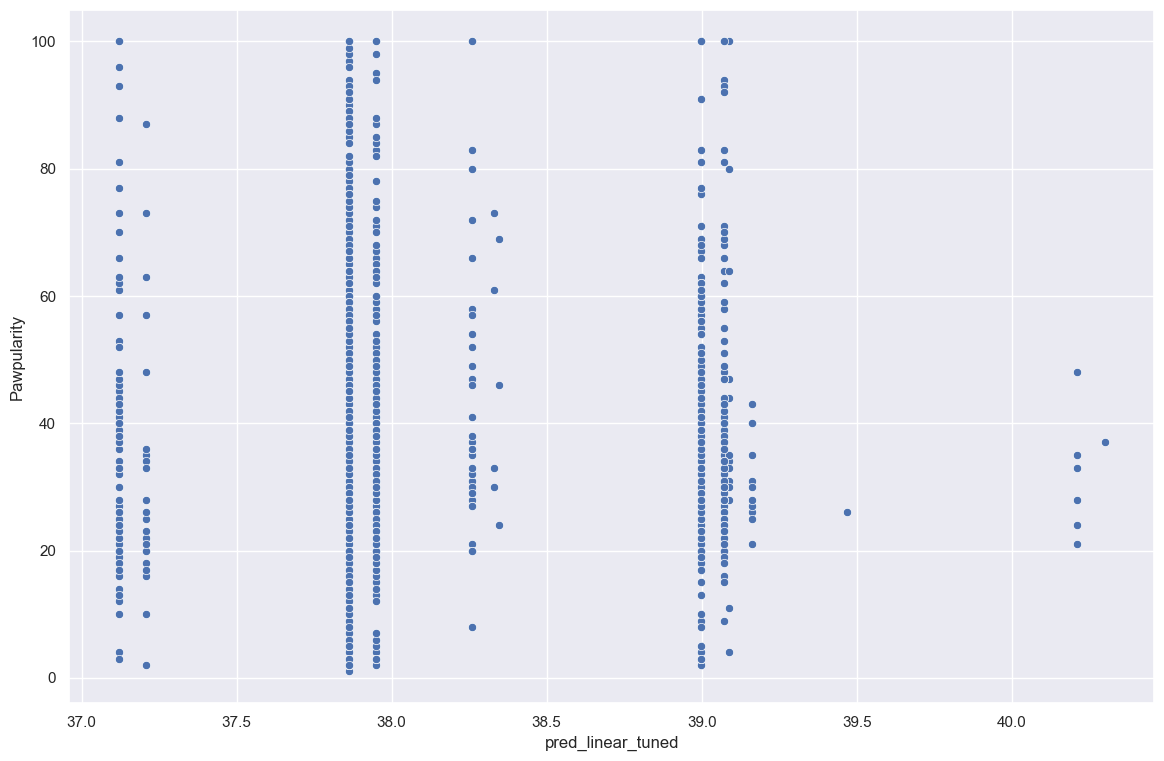

In [18]:
# True value / pred value plot:
sns.scatterplot(x=test_copy.pred_linear_tuned, y=test.Pawpularity)

<AxesSubplot: ylabel='Count'>

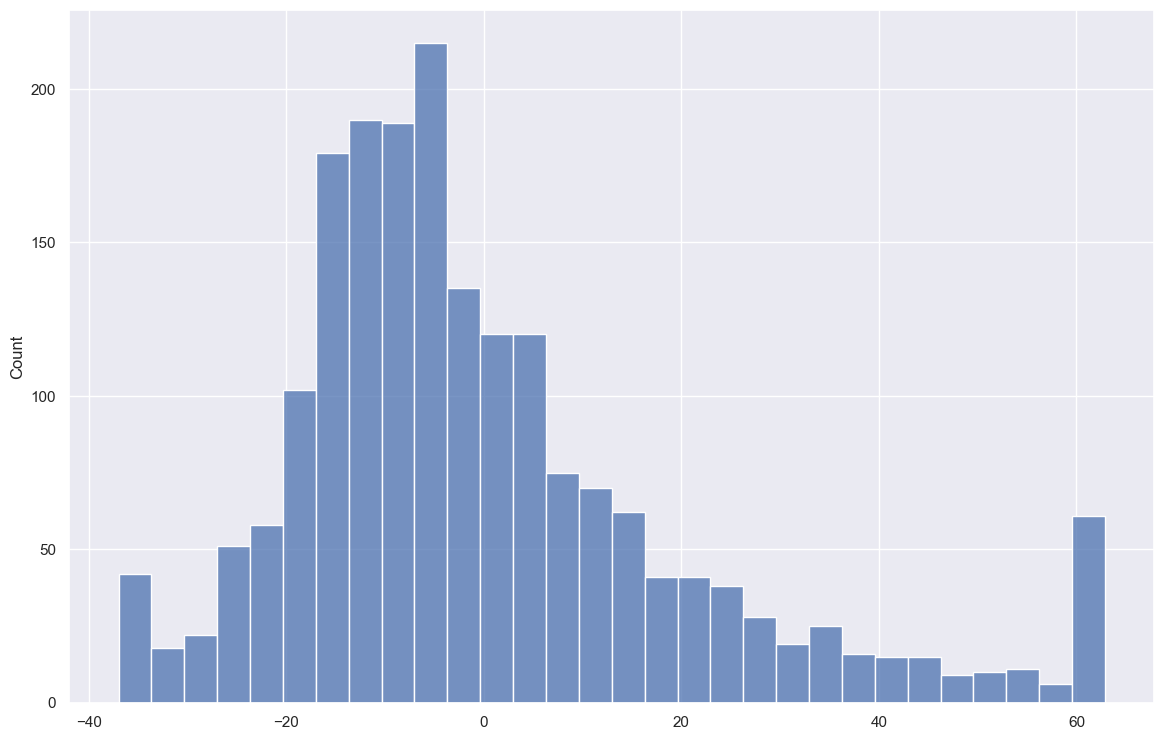

In [19]:
# Errors distribution:
sns.histplot(test.Pawpularity - test_copy.pred_linear_tuned)

**Compare several regression models (L1, L2 regularization), select the best. Don't forget to tune hyperparams**


In [20]:
# Let's try Lasso regression without tuning
model = Lasso()
model.fit(X_train, y_train)
test_copy['pred_lasso_basic'] = model.predict(X_test)

In [21]:
print_model_results(model, test_copy, 'pred_lasso_basic', 'Lasso', min_error)

Lasso mean squared error: 20.61751
Bias: 38.03493504855594
Coefs:
[('Subject Focus', -0.0),
 ('Eyes', 0.0),
 ('Face', 0.0),
 ('Near', -0.0),
 ('Action', -0.0),
 ('Accessory', 0.0),
 ('Group', 0.0),
 ('Collage', 0.0),
 ('Human', -0.0),
 ('Occlusion', -0.0),
 ('Info', -0.0),
 ('Blur', -0.0)]


In [22]:
# Define the hyperparameters to tune for Lasso
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'alpha': np.arange(0.01, 1.0, 0.01)
}

# Create an instance of the linear regression model
model = Lasso()

# # Create an instance of StandardScaler
# scaler = StandardScaler()

# Create an instance of GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'alpha': 0.12, 'fit_intercept': True, 'positive': False}
Best score:  -0.0008045389102725453


In [23]:
model = Lasso(fit_intercept=True, positive=False, alpha=0.12)
model.fit(X_train, y_train)
test_copy['pred_lasso_tuned'] = model.predict(X_test)

In [24]:
print_model_results(model, test_copy, 'pred_lasso_tuned', 'Lasso tuned', min_error)

Lasso tuned mean squared error: 20.61965
Bias: 38.08362995116658
Coefs:
[('Subject Focus', -0.0),
 ('Eyes', -0.0),
 ('Face', 0.0),
 ('Near', -0.0),
 ('Action', -0.0),
 ('Accessory', 0.0),
 ('Group', 0.0),
 ('Collage', 0.0),
 ('Human', -0.0),
 ('Occlusion', -0.0),
 ('Info', -0.0),
 ('Blur', -0.6931811181324463)]


In [25]:
# Define the hyperparameters to tune for Ridge
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'alpha': np.arange(0.01, 1, 0.01),
}

# Create an instance of the linear regression model
model = Ridge()

# # Create an instance of StandardScaler
# scaler = StandardScaler()

# Create an instance of GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'alpha': 0.99, 'fit_intercept': True, 'positive': True}
Best score:  -0.0025971108805160183


In [26]:
model = Ridge(fit_intercept=True, positive=True, alpha=0.99)
model.fit(X_train, y_train)
test_copy['pred_ridge_tuned'] = model.predict(X_test)

In [27]:
print_model_results(model, test_copy, 'pred_ridge_tuned', 'Ridge tuned', min_error)

Ridge tuned mean squared error: 20.61291
Bias: 37.064821669161546
Coefs:
[('Subject Focus', 0.0),
 ('Eyes', 0.0),
 ('Face', 0.7979929950765915),
 ('Near', 0.002590724525966333),
 ('Action', 0.0),
 ('Accessory', 1.2351893682481199),
 ('Group', 1.1279204152619917),
 ('Collage', 0.0),
 ('Human', 0.09879627072400136),
 ('Occlusion', 0.0),
 ('Info', 0.0),
 ('Blur', 0.0)]


### Polinomial Regression
Do polynomial features improve the score?

[make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) helps to combine several steps into one model

In [28]:
model = make_pipeline(
    PolynomialFeatures(degree=3),
    Ridge(fit_intercept=True, positive=True, alpha=0.99),
)
model.fit(X_train, y_train)
test_copy['pred_ridge_poly_pipeline'] = model.predict(X_test)
print_model_results(
    model,
    test_copy,
    'pred_ridge_poly_pipeline',
    'Ridge tuned with polinominal features',
    min_error)

Ridge tuned with polinominal features mean squared error: 20.60511


In [29]:
model = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression(fit_intercept=True, positive=True, n_jobs=-1),
)
model.fit(X_train, y_train)
test_copy['pred_linear_poly_pipeline'] = model.predict(X_test)
print_model_results(
    model,
    test_copy, 
    'pred_linear_poly_pipeline',
    'LinearRegression tuned with polinominal features',
    min_error)

LinearRegression tuned with polinominal features mean squared error: 20.59949


In [30]:
model = make_pipeline(
    PolynomialFeatures(degree=3),
    Lasso(fit_intercept=True, positive=False, alpha=0.12),
)
model.fit(X_train, y_train)
test_copy['pred_lasso_poly_pipeline'] = model.predict(X_test)
print_model_results(
    model,
    test_copy,
    'pred_lasso_poly_pipeline',
    'Lasso tuned with polinominal features',
    min_error)


Lasso tuned with polinominal features mean squared error: 20.61965


In [31]:
print(f'Lowest error so far is {min_error[0]:.5f} using {min_error[1]}')

Lowest error so far is 20.59949 using LinearRegression tuned with polinominal features


### Feature selection

Let's use Lasso for feature selection. Sklearn's [SelectFromModel](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel) will help

In [32]:
model = make_pipeline(
    PolynomialFeatures(degree=3),
    SelectFromModel(Lasso(fit_intercept=True, positive=False, alpha=0.12)),
    Lasso(fit_intercept=True, positive=False, alpha=0.12),
)
model.fit(X_train, y_train)
test_copy['pred_lasso_poly_selection'] = model.predict(X_test)
print_model_results(
    model,
    test_copy,
    'pred_lasso_poly_selection',
    'Lasso tuned with polinominal features and feature selection',
    min_error)


Lasso tuned with polinominal features and feature selection mean squared error: 20.61965


In [33]:
model = make_pipeline(
    PolynomialFeatures(degree=3),
    SelectFromModel(LinearRegression(fit_intercept=True, positive=True, n_jobs=-1)),
    LinearRegression(fit_intercept=True, positive=True, n_jobs=-1),
)
model.fit(X_train, y_train)
test_copy['pred_linear_poly_selection'] = model.predict(X_test)
print_model_results(
    model,
    test_copy,
    'pred_linear_poly_selection',
    'LinearRegression tuned with polinominal features and feature selection',
    min_error)


LinearRegression tuned with polinominal features and feature selection mean squared error: 20.59820


### Overal result

In [34]:
print(f'Lowest error overall was achived is {min_error[0]:.5f} using {min_error[1]}')

Lowest error overall was achived is 20.59820 using LinearRegression tuned with polinominal features and feature selection
